In [1]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/')

In [2]:
from model import build_resunet
from metrics import dice_loss,dice_coef,iou


In [3]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision


In [ ]:

""" Global Parameters """
H = 512
W = 512

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def load_data(path, split=0.2):
    images = sorted(glob(os.path.join(path, "Original_Images", "*.png")))
    masks = sorted(glob(os.path.join(path, "HardExudate_Masks", "*.png")))
    print(len(images))
    print(len(masks))
    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    threshold,thresh = cv2.threshold(x,100,255,cv2.THRESH_BINARY)
    x = thresh
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/files")

    """ Hyperparameters """
    batch_size = 4
    lr = 1e-4
    num_epochs = 50
    model_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/files/", "model.h5")
    csv_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/files/", "data.csv")

    """ Dataset """
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(dataset_path)
    train_x, train_y = shuffling(train_x, train_y)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Valid: {len(valid_x)} - {len(valid_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    train_dataset = tf_dataset(train_x, train_y, batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch_size)

    train_steps = len(train_dataset)
    valid_steps = len(valid_dataset)

    """ Model """
    model = build_resunet((H, W, 3))
    metrics = [dice_coef, iou, Recall(), Precision()]
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        TensorBoard(),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
    ]

900
900
Train: 540 - 540
Valid: 180 - 180
Test: 180 - 180


In [ ]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
    )

Epoch 1/50
135/135 [==============================] - ETA: 0s - loss: 0.3246 - dice_coef: 0.6754 - iou: 0.5274 - recall_3: 0.6564 - precision_3: 0.6963
Epoch 1: val_loss improved from inf to 1.00000, saving model to /content/drive/MyDrive/Colab Notebooks/ISIC_challenge/files/model.h5
135/135 [==============================] - 181s 1s/step - loss: 0.3246 - dice_coef: 0.6754 - iou: 0.5274 - recall_3: 0.6564 - precision_3: 0.6963 - val_loss: 1.0000 - val_dice_coef: 1.7326e-06 - val_iou: 8.6632e-07 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
135/135 [==============================] - ETA: 0s - loss: 0.2872 - dice_coef: 0.7128 - iou: 0.5703 - recall_3: 0.6911 - precision_3: 0.7428
Epoch 2: val_loss improved from 1.00000 to 0.99300, saving model to /content/drive/MyDrive/Colab Notebooks/ISIC_challenge/files/model.h5
135/135 [==============================] - 175s 1s/step - loss: 0.2872 - dice_coef: 0.7128 - iou: 0.5703 - recall_3: 0.6911 - precision_3

In [4]:
from tensorflow.keras.utils import CustomObjectScope
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import pandas as pd

In [ ]:
def save_result(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255.0

    ori_y = np.expand_dims(ori_y, axis=-1)  ## (256, 256, 1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1) ## (256, 256, 3)

    y_pred = np.expand_dims(y_pred, axis=-1)    ## (256, 256, 1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255.0 ## (256, 256, 3)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
def read_image_(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (H, W))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

def read_mask_(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (H, W))
    ori_x = x
    x = x/np.max(x)
    x = x.astype(np.int32)
    return ori_x, x

In [ ]:

create_dir("/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/results")

""" Loading the model """
with CustomObjectScope({"iou": iou, "dice_coef": dice_coef, "dice_loss": dice_loss}):
  model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/files/model.h5")

""" Predict the mask and calculate the metrics values """
SCORE = []
for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        
      
        name = x.split("/")[-1]

        """ Reading the image and mask. """
        ori_x, x = read_image_(x)
        ori_y, y = read_mask_(y)

        """ Predict the mask """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        """ Save the image """
        save_image_path = f"/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/results/{name}"
        save_result(ori_x, ori_y, y_pred, save_image_path)

        """ Flattening the numpy arrays. """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

""" Metrics values """
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")

""" Saving all the results """
df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/files/score.csv")

100%|██████████| 180/180 [01:26<00:00,  2.07it/s]

Accuracy: 0.90161
F1: 0.80223
Jaccard: 0.70203
Recall: 0.83139
Precision: 0.85294


In [5]:
import matplotlib.pyplot as plt

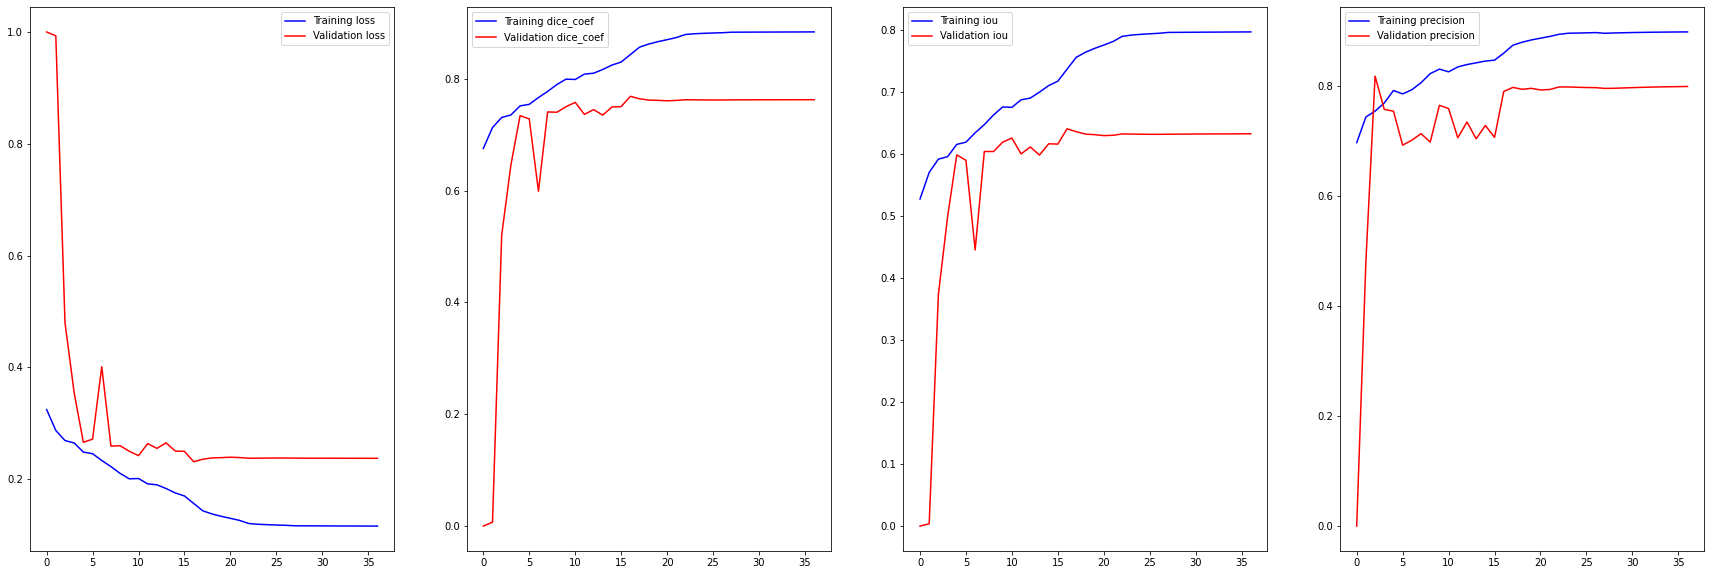

In [8]:
history = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISIC_challenge/files/data.csv', sep=',', engine='python')

hist=history

############### ########## ####### #######
epochs = hist['epoch']

n_epochs=range(len(epochs))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

train_iou=hist['iou']
val_iou=hist['val_iou']

train_precision=hist['precision_3']
val_precision=hist['val_precision_3']

f,ax=plt.subplots(1,4,figsize=(30,10))

ax[0].plot(n_epochs,loss,'b',label='Training loss')
ax[0].plot(n_epochs,val_loss,'r',label='Validation loss')
ax[0].legend()

ax[1].plot(n_epochs,train_dice,'b',label='Training dice_coef')
ax[1].plot(n_epochs,val_dice,'r',label='Validation dice_coef')
ax[1].legend()

ax[2].plot(n_epochs,train_iou,'b',label='Training iou')
ax[2].plot(n_epochs,val_iou,'r',label='Validation iou')
ax[2].legend()

ax[3].plot(n_epochs,train_precision,'b',label='Training precision')
ax[3].plot(n_epochs,val_precision,'r',label='Validation precision')
ax[3].legend()

plt.show()

In [10]:
test_path = "/content/drive/MyDrive/Colab Notebooks/ISIC_challenge"

In [11]:
images = sorted(glob(os.path.join(test_path, "results", "*.jpg")))

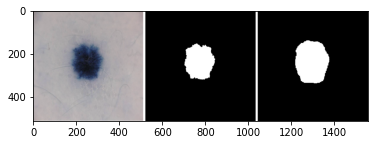

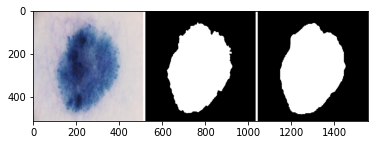

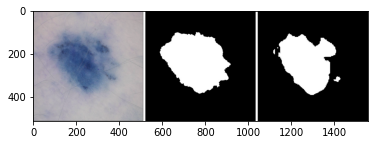

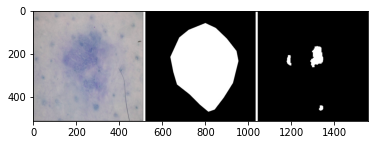

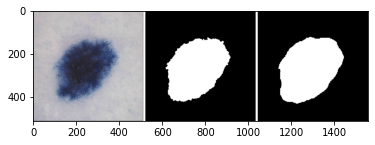

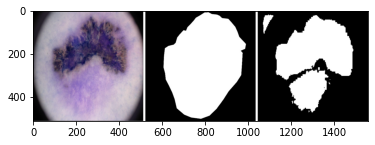

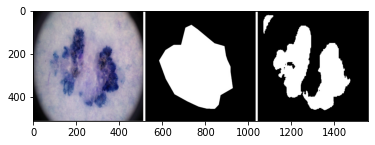

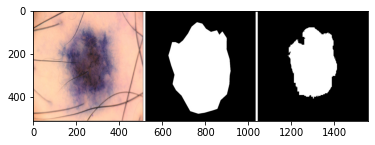

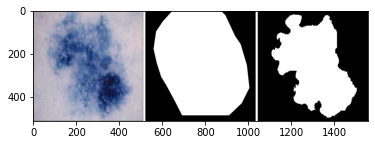

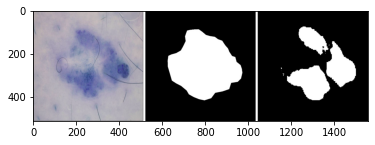

In [12]:
for i in range(10):
  x = cv2.imread(images[i],cv2.IMREAD_COLOR)
  plt.imshow(x)
  plt.show()
